In [1]:
import findspark
findspark.init('/Users/illav/spark/spark-3.0.1-bin-hadoop3.2')

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import format_number as fmt
from pyspark.sql.functions import udf
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover,Word2Vec
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import re
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

**Loading Twitter data stored in MongoDB and collected via Twitter Data API to Spark Sql DataFrame**

In [2]:
spark = SparkSession \
    .builder \
    .appName('myApp') \
    .config('spark.mongodb.input.uri', 'mongodb://127.0.0.1/twitterdb.twitter_search') \
    .config('spark.mongodb.input.twitter', 'twitter_search') \
    .config('spark.mongodb.output.uri', 'mongodb://127.0.0.1/twitterdb.twitter_search') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1')\
    .getOrCreate()

df = spark.read.format('mongo').option('uri', 'mongodb://127.0.0.1/twitterdb.twitter_search').load()

**Required Funtions to be used in Spark udf for data processing**

In [3]:
def removePattern(inputText, pattern):
    r = re.findall(pattern, inputText)
    for i in r:
        inputText = re.sub(i, '', inputText)        
    return inputText

def cleanTweet(txt):
    '''
    Remove twitter return handles (RT @xxx:)
    '''
    txt = removePattern(txt, 'RT @[\w]*:')
    '''
    Remove twitter handles (@xxx)
    '''
    txt = removePattern(txt, '@[\w]*')
    '''
    Remove URL links (httpxxx)
    '''
    txt = removePattern(txt, 'https?://[A-Za-z0-9./]*')
    '''
    Remove special characters, numbers, punctuations
    '''
    txt = re.sub('[^A-Za-z]+', ' ', txt)
    return txt

def getCleanTweetText(filteredTweetText):
    return ' '.join(filteredTweetText)

def getSentimentScore(tweetText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(tweetText)
    return float(vs['compound'])

def getSentiment(score):
    return 1 if score > 0 else 0


def getTweetArray(tweet):
    return tweet.split(' ')

#### Sentiment analysis with Vader Sentiment Classifier from Hutto AAAI 2014 paper

**Cleanup and Preparing Data For Performing Vader Sentiment Analysis**

In [4]:
udfCleanTweet = udf(cleanTweet, StringType())
dfCleanTweet=df.withColumn('cleanTweetText', udfCleanTweet('text'))
dfCleanTweet.select('text','cleanTweetText').show(5)

+--------------------+--------------------+
|                text|      cleanTweetText|
+--------------------+--------------------+
|@ReformedBroker B...|        Buy bitcoin |
|RT @DigiFinex: Fa...| Facebook has pus...|
|RT @tradingroomap...| Buying Bitcoin C...|
|Most Profound Que...|Most Profound Que...|
|Bitcoin BTC Curre...|Bitcoin BTC Curre...|
+--------------------+--------------------+
only showing top 5 rows



In [5]:
tokenizer = Tokenizer(inputCol='cleanTweetText', outputCol='words')
dfCleanTweetTokenized = tokenizer.transform(dfCleanTweet)
dfCleanTweetTokenized.select('text','cleanTweetText','words').show(5)

+--------------------+--------------------+--------------------+
|                text|      cleanTweetText|               words|
+--------------------+--------------------+--------------------+
|@ReformedBroker B...|        Buy bitcoin |    [, buy, bitcoin]|
|RT @DigiFinex: Fa...| Facebook has pus...|[, facebook, has,...|
|RT @tradingroomap...| Buying Bitcoin C...|[, buying, bitcoi...|
|Most Profound Que...|Most Profound Que...|[most, profound, ...|
|Bitcoin BTC Curre...|Bitcoin BTC Curre...|[bitcoin, btc, cu...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [6]:
remover = StopWordsRemover(inputCol='words', outputCol='filteredTweetText')
dfStopwordRemoved=remover.transform(dfCleanTweetTokenized)
dfStopwordRemoved.select('text','cleanTweetText','words','filteredTweetText').show(5)

+--------------------+--------------------+--------------------+--------------------+
|                text|      cleanTweetText|               words|   filteredTweetText|
+--------------------+--------------------+--------------------+--------------------+
|@ReformedBroker B...|        Buy bitcoin |    [, buy, bitcoin]|    [, buy, bitcoin]|
|RT @DigiFinex: Fa...| Facebook has pus...|[, facebook, has,...|[, facebook, push...|
|RT @tradingroomap...| Buying Bitcoin C...|[, buying, bitcoi...|[, buying, bitcoi...|
|Most Profound Que...|Most Profound Que...|[most, profound, ...|[profound, questi...|
|Bitcoin BTC Curre...|Bitcoin BTC Curre...|[bitcoin, btc, cu...|[bitcoin, btc, cu...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
udfCleanTweetText = udf(getCleanTweetText, StringType())
dfFilteredCleanedTweet = dfStopwordRemoved.withColumn('filteredCleanedTweetText', udfCleanTweetText('filteredTweetText'))
dfFilteredCleanedTweet.select('filteredCleanedTweetText').show(5)

+------------------------+
|filteredCleanedTweetText|
+------------------------+
|             buy bitcoin|
|     facebook pushed ...|
|     buying bitcoin c...|
|    profound question...|
|    bitcoin btc curre...|
+------------------------+
only showing top 5 rows



In [8]:
udfSentimentScore = udf(getSentimentScore, FloatType())
dfSentimentScore = dfFilteredCleanedTweet.withColumn('sentimentScore', udfSentimentScore('filteredCleanedTweetText'))
dfSentimentScore.select('filteredCleanedTweetText','sentimentScore').show(5)

+------------------------+--------------+
|filteredCleanedTweetText|sentimentScore|
+------------------------+--------------+
|             buy bitcoin|           0.0|
|     facebook pushed ...|           0.0|
|     buying bitcoin c...|       -0.7003|
|    profound question...|           0.0|
|    bitcoin btc curre...|           0.0|
+------------------------+--------------+
only showing top 5 rows



In [9]:
udfSentiment = udf(getSentiment, IntegerType())
dfSentiment = dfSentimentScore.withColumn('sentiment', udfSentiment('sentimentScore'))
dfSentiment.select('filteredCleanedTweetText','sentimentScore','sentiment').show(5)

+------------------------+--------------+---------+
|filteredCleanedTweetText|sentimentScore|sentiment|
+------------------------+--------------+---------+
|             buy bitcoin|           0.0|        0|
|     facebook pushed ...|           0.0|        0|
|     buying bitcoin c...|       -0.7003|        0|
|    profound question...|           0.0|        0|
|    bitcoin btc curre...|           0.0|        0|
+------------------------+--------------+---------+
only showing top 5 rows



In [10]:
dfSentiment.groupBy('sentiment').count().show()

dfPlotVaderSentiment=dfSentiment.groupBy('sentiment').count().toPandas()
dfPlotVaderSentiment

+---------+-----+
|sentiment|count|
+---------+-----+
|        1|27835|
|        0|25453|
+---------+-----+



,sentiment,count
0,1,27835
1,0,25453


**Visualization For Twitter Sentiment Analyzed By Vader Sentiment Analysis**
* **Number of occurrences for each type of Sentiment**

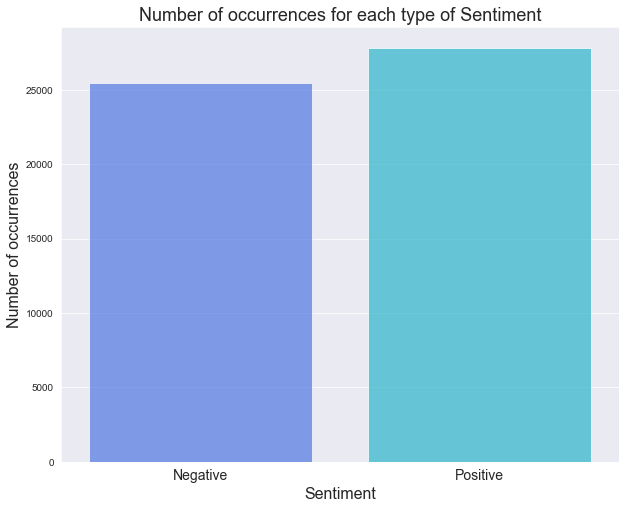

In [11]:
sentimentsList=['Negative','Positive']
sns.set_style('darkgrid')
sns.set_palette('rainbow')
plt.figure(figsize=(10,8))
sns.barplot(x='sentiment', y='count',data=dfPlotVaderSentiment, alpha=0.7)
plt.title('Number of occurrences for each type of Sentiment',fontsize=18)
plt.xticks(np.arange(2),sentimentsList)
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.xlabel('Sentiment',fontsize=16)
plt.ylabel('Number of occurrences',fontsize=16)
plt.show()

* **Percentage distribution of each type of sentiment in all Tweets**

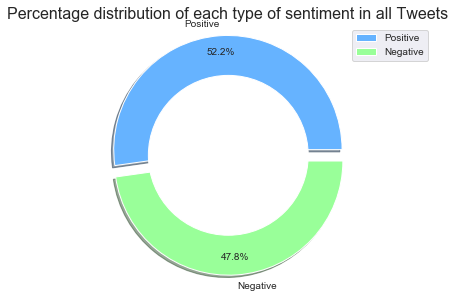

In [12]:
labels = ['Positive' if sentiment==1 else 'Negative' for sentiment in dfPlotVaderSentiment['sentiment'].tolist() ]
sizes = dfPlotVaderSentiment['count'].tolist()
explode = (0.05,0.05)
colors = ['#66b3ff','#99ff99']

plt.pie(dfPlotVaderSentiment['count'],  labels=labels, colors=colors, shadow=True, autopct='%1.1f%%'
        ,explode=explode, pctdistance=0.85)

'''
draw circle
'''
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.title('Percentage distribution of each type of sentiment in all Tweets',fontsize=16)
plt.legend(loc='upper right', labels=labels)
plt.show()

**Visualization with WordCloud**

**Extracting words from Spark DataFrame to create wordcloud visualization**

In [13]:
dfSentiment.select('filteredCleanedTweetText','sentimentScore','sentiment').show(5)

+------------------------+--------------+---------+
|filteredCleanedTweetText|sentimentScore|sentiment|
+------------------------+--------------+---------+
|             buy bitcoin|           0.0|        0|
|     facebook pushed ...|           0.0|        0|
|     buying bitcoin c...|       -0.7003|        0|
|    profound question...|           0.0|        0|
|    bitcoin btc curre...|           0.0|        0|
+------------------------+--------------+---------+
only showing top 5 rows



In [14]:
filteredCleanedTweetTextRddList = dfSentiment.select('filteredCleanedTweetText').collect()
filteredCleanedTweetTextList = [row.filteredCleanedTweetText for row in filteredCleanedTweetTextRddList]
wordList = []
for filteredCleanedTweetText in filteredCleanedTweetTextList:
     wordList.append(filteredCleanedTweetText.split(' '))
allTweetWords = [word for subList in wordList for word in subList]
'''
Remove empty strings
'''
allTweetWords = list(filter(None, allTweetWords))

In [15]:
allTweetWords=set(allTweetWords)
frequencyDistribution = nltk.FreqDist(allTweetWords)
sorted(frequencyDistribution,key=frequencyDistribution.__getitem__, reverse=True)[0:100]

['correctly',
 'pagos',
 'publicado',
 'lager',
 'bitcoinasia',
 'arbitraj',
 'tops',
 'means',
 'hardcap',
 'watches',
 'lamp',
 'messages',
 'pontos',
 'heasley',
 'cannabis',
 'liechtenstein',
 'known',
 'historically',
 'bitcoinnetwork',
 'gonna',
 'nah',
 'comerica',
 'accommodation',
 'inception',
 'accelerating',
 'te',
 'bitball',
 'vistazo',
 'towns',
 'voir',
 'progressed',
 'illuminating',
 'dovish',
 'ledgers',
 'basher',
 'mybd',
 'doncaster',
 'encryption',
 'efficacy',
 'andr',
 'suggests',
 'midlands',
 'normativa',
 'attracted',
 'hizmeti',
 'environmental',
 'strives',
 'validation',
 'abbau',
 'blt',
 'hedgefund',
 'precisa',
 'svte',
 'steadily',
 'tnetworks',
 'dilemma',
 'artificialintelligence',
 'pending',
 'billiin',
 'wp',
 'payoff',
 'clubjack',
 'eldatodeld',
 'primero',
 'burda',
 'agricoinx',
 'finnaly',
 'soleimani',
 'fiatmoney',
 'eastern',
 'cryptio',
 'hammer',
 'menerangkan',
 'sora',
 'streets',
 'neighbour',
 'sudwatoken',
 'oooh',
 'ny',
 'even',


### Next I have shown few WordCloud visualizations for Tweets regarding Bitcoin

In [17]:
def getWordCloud(wordList,color):
    stopWords = set(STOPWORDS)
    allWords = ' '.join([word for word in wordList])
    wordCloud = WordCloud(background_color=color,
                          stopwords=stopWords,
                          width=1600,
                          height=800,
                          random_state=21,
                          max_words=50,
                          max_font_size=200).generate(allWords)
    
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(wordCloud, interpolation='bilinear');

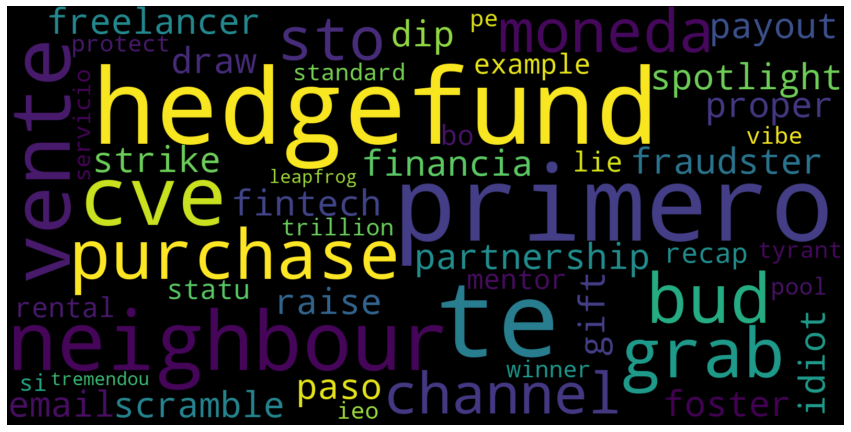

In [18]:
getWordCloud(allTweetWords,'black')

**Word2Vec - Exploring the data a little; analyzing how Word2Vec similar words behave for Tweets**

In [19]:
udfTweetArray = udf(getTweetArray, ArrayType(StringType()))
dfWord2Vec = dfSentiment.withColumn('filteredCleanedTweetArrayForW2V', udfTweetArray('filteredCleanedTweetText'))
dfWord2Vec.select('filteredCleanedTweetText','filteredCleanedTweetArrayForW2V').show(5)

+------------------------+-------------------------------+
|filteredCleanedTweetText|filteredCleanedTweetArrayForW2V|
+------------------------+-------------------------------+
|             buy bitcoin|               [, buy, bitcoin]|
|     facebook pushed ...|           [, facebook, push...|
|     buying bitcoin c...|           [, buying, bitcoi...|
|    profound question...|           [profound, questi...|
|    bitcoin btc curre...|           [bitcoin, btc, cu...|
+------------------------+-------------------------------+
only showing top 5 rows



In [20]:
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol='filteredCleanedTweetArrayForW2V', outputCol='wrdVector')
modelW2V = word2Vec.fit(dfWord2Vec)
wrdVec = modelW2V.transform(dfWord2Vec)
wrdVec.select('wrdVector').show(5, truncate = True)

+--------------------+
|           wrdVector|
+--------------------+
|[-0.0081031260391...|
|[0.03244456322863...|
|[0.05897613765242...|
|[-0.0681024376302...|
|[-0.1719806233627...|
+--------------------+
only showing top 5 rows



In [21]:
dfWordVectors = modelW2V.getVectors()
dfWordVectors.show(5)

+--------+--------------------+
|    word|              vector|
+--------+--------------------+
| serious|[0.00916644185781...|
|  breaks|[5.09095494635403...|
|precious|[0.05938430503010...|
|   retwe|[0.06232949718832...|
| sectors|[-0.0720720514655...|
+--------+--------------------+
only showing top 5 rows



**Let's explore the data a little**

In [22]:
topN=10

dfSynonyms = modelW2V.findSynonyms('btc', topN).toPandas()
dfSynonyms[['word']].head(topN)

,word
0,ltc
1,eth
2,price
3,bitcoin
4,btcusd
5,giveawayalert
6,bitcoincash
7,coinbase
8,prediction
9,gained


In [23]:
dfSynonyms = modelW2V.findSynonyms('bitcoin', topN).toPandas()
dfSynonyms[['word']].head(topN)

,word
0,via
1,litecoin
2,btc
3,ethereum
4,still
5,analysis
6,price
7,coinbase
8,bitcoins
9,sell


In [24]:
dfSimilarity=modelW2V.findSynonyms('litecoin', topN).select('word', fmt('similarity', 5).alias('similarity')).toPandas()
dfSimilarity.head(topN)

,word,similarity
0,ltc,0.73554
1,bitcoincash,0.70471
2,hitting,0.64089
3,dailycoin,0.63667
4,eur,0.63521
5,price,0.63315
6,tether,0.62944
7,ltcbtc,0.61391
8,forecast,0.59987
9,dogecoin,0.59245


In [25]:
dfSimilarity=modelW2V.findSynonyms('blockchain', topN).select('word', fmt('similarity', 5).alias('similarity')).toPandas()
dfSimilarity.head(topN)

,word,similarity
0,tokensale,0.48864
1,technology,0.47616
2,ieo,0.47388
3,stories,0.43097
4,iot,0.42421
5,fintech,0.41513
6,ether,0.41244
7,cryptoenergy,0.40820
8,finance,0.40691
9,solution,0.40449


## Sentiment Analysis with Logistic Regression Classifier


In [26]:
dfSentiment = dfSentiment.withColumnRenamed('sentiment','target')

In [27]:
dfSentimnetAnalysisW2VLogreg=dfSentiment.select('text','cleanTweetText','target')
dfSentimnetAnalysisW2VLogreg.show(5)

+--------------------+--------------------+------+
|                text|      cleanTweetText|target|
+--------------------+--------------------+------+
|@ReformedBroker B...|        Buy bitcoin |     0|
|RT @DigiFinex: Fa...| Facebook has pus...|     0|
|RT @tradingroomap...| Buying Bitcoin C...|     0|
|Most Profound Que...|Most Profound Que...|     0|
|Bitcoin BTC Curre...|Bitcoin BTC Curre...|     0|
+--------------------+--------------------+------+
only showing top 5 rows



In [28]:
w2vLogreg = PipelineModel.load('W2VLogreg.model')
predictions = w2vLogreg.transform(dfSentimnetAnalysisW2VLogreg)
predictions.printSchema()

root
 |-- text: string (nullable = true)
 |-- cleanTweetText: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- tokenTweet: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filteredTokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [30]:
evaluator = BinaryClassificationEvaluator()
roc_accuracy=evaluator.evaluate(predictions)
print('ROC-Accuracy of logistic regression model with word2vec word embedding at predicting vader sentiment is: {:.4f}'.format(roc_accuracy))


ROC-Accuracy of logistic regression model with word2vec word embedding at predicting vedar sentiment is: 0.7075


**Perfromance comparision of  my own classifiers and Vader Sentiment Analysis**

In [31]:
sample1 = dfSentimnetAnalysisW2VLogreg.sample(False, 0.1, 101)
sample2 = dfSentimnetAnalysisW2VLogreg.sample(False, 0.2, 101)
sample3 = dfSentimnetAnalysisW2VLogreg.sample(False, 0.3, 101)

predictions1 = w2vLogreg.transform(sample1)
predictions2 = w2vLogreg.transform(sample2)
predictions3 = w2vLogreg.transform(sample3)

In [32]:
numberOfRecInSample1 = sample1.agg({'target':'count'}).collect()[0]['count(target)']
numberOfRecInSample2 = sample2.agg({'target':'count'}).collect()[0]['count(target)']
numberOfRecInSample3 = sample3.agg({'target':'count'}).collect()[0]['count(target)']

numOfRecInSamplesList=[numberOfRecInSample1,numberOfRecInSample2,numberOfRecInSample3]
print(numOfRecInSamplesList)

[5286, 10602, 15967]


In [33]:
matchedPredictionsPercent1 = ((predictions1.filter(predictions1['label'] == predictions1['prediction']).count())/numberOfRecInSample1)*100
matchedPredictionsPercent2 = ((predictions2.filter(predictions2['label'] == predictions2['prediction']).count())/numberOfRecInSample2)*100
matchedPredictionsPercent3 = ((predictions3.filter(predictions3['label'] == predictions3['prediction']).count())/numberOfRecInSample3)*100

predMatchWithVSList = [matchedPredictionsPercent1,matchedPredictionsPercent2,matchedPredictionsPercent3]

print('predMatchWithVSList : ',predMatchWithVSList)


predMatchWithVSList :  [57.90768066590996, 58.01735521599698, 57.66894219327363]


* **Visualization of Perfromance Comparision of  Own classifier Logistic Regression with Word2Vec Word Embedding and Vader Sentiment Analysis**

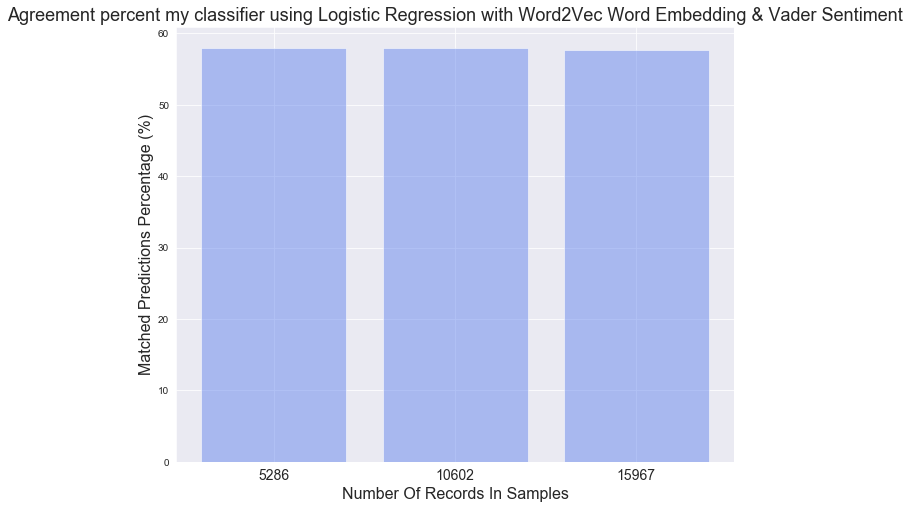

In [35]:
sns.set_palette('coolwarm')
sns.set_style('darkgrid')
xPos = np.arange(len(numOfRecInSamplesList))
plt.figure(figsize=(10,8))
plt.bar(xPos, predMatchWithVSList, align='center', alpha=0.5)
plt.title('Agreement percent my classifier using Logistic Regression with Word2Vec Word Embedding & Vader Sentiment',fontsize=18)
plt.xticks(xPos,numOfRecInSamplesList)
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.xlabel('Number Of Records In Samples',fontsize=16)
plt.ylabel('Matched Predictions Percentage (%)',fontsize=16)
plt.show()

**Determining the distribution of tweets across Countries (geographies)**

In [36]:
dfSentiment.where(dfSentiment.place.isNotNull()).select('place').toPandas()['place'].tolist()[:5]

[Row(id='0c2e6999105f8070', url='https://api.twitter.com/1.1/geo/id/0c2e6999105f8070.json', place_type='city', name='Anaheim', full_name='Anaheim, CA', country_code='US', country='United States', bounding_box=Row(type='Polygon', coordinates=[[[-118.017789, 33.788913], [-118.017789, 33.896813], [-117.684389, 33.896813], [-117.684389, 33.788913]]])),
 Row(id='6ab2f5132f36eb85', url='https://api.twitter.com/1.1/geo/id/6ab2f5132f36eb85.json', place_type='city', name='Kuta', full_name='Kuta, Indonesia', country_code='ID', country='Indonesia', bounding_box=Row(type='Polygon', coordinates=[[[115.083847, -8.849261], [115.083847, -8.601695], [115.240267, -8.601695], [115.240267, -8.849261]]])),
 Row(id='1927193c57f35d51', url='https://api.twitter.com/1.1/geo/id/1927193c57f35d51.json', place_type='city', name='West Hollywood', full_name='West Hollywood, CA', country_code='US', country='United States', bounding_box=Row(type='Polygon', coordinates=[[[-118.395904, 34.075963], [-118.395904, 34.09805

In [37]:
def getCountry(place):
    if place:
        return place[6]
    else:
        return 'None'

In [38]:
udfCountry = udf(getCountry, StringType())
dfCountry = dfSentiment.withColumn('country', udfCountry('place'))

In [39]:
dfCountryWiseTweetCount = dfCountry.groupBy('country')\
                                   .agg(F.count('text').alias('numberOfTweets'))\
                                   .orderBy('numberOfTweets', ascending=False)

dfCountryWiseTweetCount.cache()
dfCountryWiseTweetCount=dfCountryWiseTweetCount.filter(~dfCountryWiseTweetCount['country'].isin(['None']))
dfCountryWiseTweetCount.show(5)

+--------------------+--------------+
|             country|numberOfTweets|
+--------------------+--------------+
|       United States|            84|
|               India|            38|
|      United Kingdom|            17|
|           Indonesia|            11|
|Republic of the P...|             4|
+--------------------+--------------+
only showing top 5 rows



In [40]:
dfPlotCountryWiseTweetCount = dfCountryWiseTweetCount.toPandas()

### Distribution of country-wise tweets about bitcoin visualized

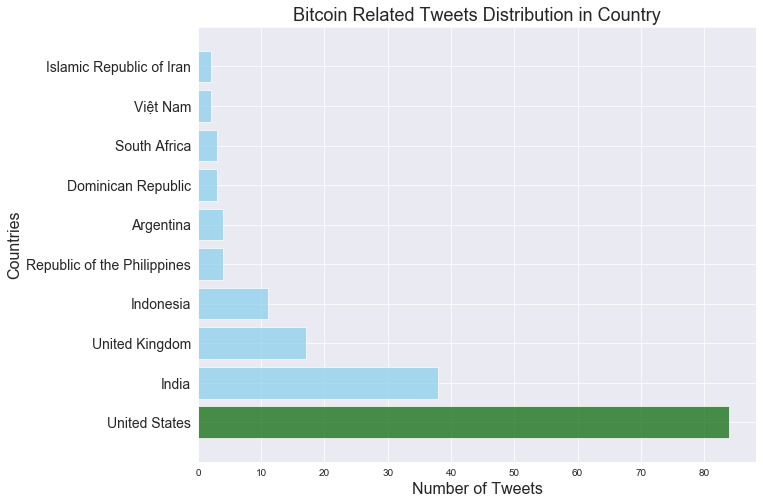

In [41]:
numberOfPlottedCountries = 10

countries = dfPlotCountryWiseTweetCount['country'][:numberOfPlottedCountries].tolist()
numberOfTweets = dfPlotCountryWiseTweetCount['numberOfTweets'][:numberOfPlottedCountries].tolist()
yPos = np.arange(len(countries))
colors = np.repeat('skyblue', numberOfPlottedCountries - 1).tolist()
colors = ['darkgreen'] + colors

plt.figure(figsize=(10,8))
plt.barh(yPos, numberOfTweets, align='center', color=colors, alpha=.7)
plt.title('Bitcoin Related Tweets Distribution in Country',fontsize=18)
plt.yticks(yPos, countries)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)
plt.xlabel('Number of Tweets',fontsize=16)
plt.ylabel('Countries',fontsize=16)
plt.ylim(-1, len(yPos))
plt.show()

**Geo-distribution of tweets across the globe about bitcoin**

In [42]:
sumOfTweets = dfCountryWiseTweetCount.agg({'numberOfTweets':'sum'}).collect()[0]
totalNumberOfTweets = sumOfTweets['sum(numberOfTweets)']
dfCountryWiseTweetPercent=dfCountryWiseTweetCount.withColumn('percentage', (dfCountryWiseTweetCount['numberOfTweets']/totalNumberOfTweets)*100)
dfCountryWiseTweetPercent.select('country','percentage').show(10)

+--------------------+------------------+
|             country|        percentage|
+--------------------+------------------+
|       United States|42.857142857142854|
|               India|19.387755102040817|
|      United Kingdom| 8.673469387755102|
|           Indonesia| 5.612244897959184|
|Republic of the P...|2.0408163265306123|
|           Argentina|2.0408163265306123|
|  Dominican Republic| 1.530612244897959|
|        South Africa| 1.530612244897959|
|            Việt Nam|1.0204081632653061|
|Islamic Republic ...|1.0204081632653061|
+--------------------+------------------+
only showing top 10 rows



In [43]:
def getFormatedCountryName(country):
    if country=='United States':
        return 'United States of America'
    elif country=='Republic of the Philippines':
        return 'Philippines' 
    elif country=='Việt Nam':
        return 'Viet Nam'
    elif country=='Islamic Republic of Iran':
        return 'Iran'
    else:
        return country
    
udfFormatedCountryName = udf(getFormatedCountryName, StringType())
dfCountryWiseTweetPercent = dfCountryWiseTweetPercent.withColumn('countryName',
                                                                 udfFormatedCountryName('country'))


dfCountryWiseTweetPercent.show(10)

+--------------------+--------------+------------------+--------------------+
|             country|numberOfTweets|        percentage|         countryName|
+--------------------+--------------+------------------+--------------------+
|       United States|            84|42.857142857142854|United States of ...|
|               India|            38|19.387755102040817|               India|
|      United Kingdom|            17| 8.673469387755102|      United Kingdom|
|           Indonesia|            11| 5.612244897959184|           Indonesia|
|Republic of the P...|             4|2.0408163265306123|         Philippines|
|           Argentina|             4|2.0408163265306123|           Argentina|
|  Dominican Republic|             3| 1.530612244897959|  Dominican Republic|
|        South Africa|             3| 1.530612244897959|        South Africa|
|            Việt Nam|             2|1.0204081632653061|            Viet Nam|
|Islamic Republic ...|             2|1.0204081632653061|        

In [44]:
dfPlotCountryWiseTweetPercent = dfCountryWiseTweetPercent.select('countryName','percentage').toPandas()
dfPlotCountryWiseTweetPercent.head(5)

,countryName,percentage
0,United States of America,42.857143
1,India,19.387755
2,United Kingdom,8.673469
3,Indonesia,5.612245
4,Philippines,2.040816
